# Python for STEM - Week 2 (Advanced)  

## Day 3 - Part 1: Unsupervised learning - clustering

In this notebook, we will focus on examples of unsupervised machine learning. More specifically, we will be doing clustering using Scikit-learn, one of the machine learning packages in Python. Before we start, here we first import all the packages that we need for this notebook. 

All the machine learning functions we will use in Day 3 and Day 4 all comes from [scikit-learn](https://scikit-learn.org/stable/index.html). You can find very detailed descriptions on many machine learning models included in the package user guide and various examples. This would be a good place to start when you want to adopt machine learning for your own research/work.  




In [1]:
## In this cell, we import all the packages needed for this notebook
import numpy as np                  ## packages for data handling
import pandas as pd                 
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt     ## packages for visualization 
import seaborn as sbn 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data ingest  
In this notebook, we will use a dataset from geography/remote sensing. The data includes 1875 data points (locations) in the western North Carolina (Asheville region). Each row of the data contains the information of a point with its latitude/longitude, land cover type (forest, crop, urban, or water), and the surface reflectance data of six channels from the OLI sensor onboard USGS/NASA Land resource satellite Landsat-8. The reflectance data provide unique feature of the land surface as seen by the satellite sensor, which allows geographer understand how the surface is changing through time. To find more information about the data and satellite, you can visit USGS website about [Landsat-8 OLI data.](https://www.usgs.gov/land-resources/nli/landsat/landsat-8?qt-science_support_page_related_con=0#qt-science_support_page_related_con)

In [2]:
## First we use pandas to read in the comma separated values (CSV) file
datafile = 'https://raw.githubusercontent.com/geo-yrao/STEM_Python_Course/geo-yrao-patch-1/02_Week2/Data/03_land_use_land_cover_asheville.csv'
AVLData = pd.read_csv(datafile, index_col=None)

## We will check the first five rows of the data to have initial understadning of our data
print( AVLData.head() )

    Latitude  Longitude  Class   B1   B2   B3   B4    B5    B6
0  35.514769 -82.680451      0  127  150  550  226  3609  1441
1  35.753979 -82.520432      0   81  115  426  170  2913  1110
2  35.710635 -82.305661      0  156  220  538  477  2492  2077
3  35.512814 -82.413861      0  245  280  663  507  2732  1531
4  35.520636 -82.853181      0  148  181  534  265  3320  1457


In this dataset, **Class** refers to the land cover type, **B1** ~ **B6** are the surface reflectances of the sixe OLI channels. The table below explains what the class code represents.

| Class No. | Land Cover Type |
|-:|-:|
|0|Forest| 
|1|Crop|
|2|Development/Urban|
|3|Water|

Additionally, the following table gives us a quick explaination of what are the six OLI channels.  

| Channel No. | Channel Name | Wavelength |
|-:|-:|:-:|
|B1|Coastal/Areasol|0.433 – 0.453 μm| 
|B2|Blue|0.450 – 0.515 μm|
|B3|Green|0.525 – 0.600 μm|
|B4|Red|0.630 – 0.680 μm|
|B5|Near Infrared|0.845 – 0.885 μm|
|B6|Short Wavelength Infrared|1.560 – 1.660 μm|  

Typically, refletance value is between 0 and 1, describing the percentage of light reflected by the surface. The reflectance value in our data is the scaled value between 0 and 10000. You can simply convert it back to regular reflectance by multiplying 0.0001.   


In this notebook, we are doing clustering, so the **Class** information is not relevant because we are trying to guess how many clusters that we have based on this dataset. So let's assume that we do not have the land cover information.

    B1   B2   B3   B4    B5    B6
0  127  150  550  226  3609  1441
1   81  115  426  170  2913  1110
2  156  220  538  477  2492  2077
3  245  280  663  507  2732  1531
4  148  181  534  265  3320  1457


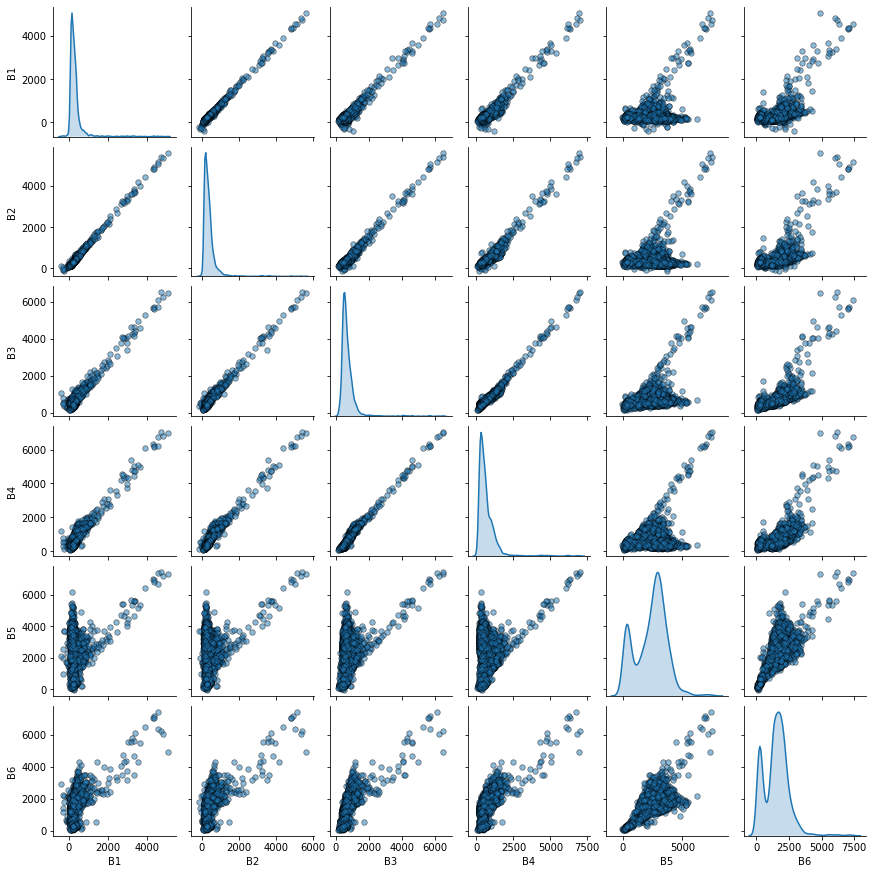

In [3]:
## Now we have a simple matrix with six columns (attributes)
## X is the new pandas data.frame with only the six channel reflectance
X = AVLData.iloc[:,3:]
print( X.head() )
## We are now looking at the pairwise scatter plots between these six channels
## using seaborn.pairplot function to look at them in one bix plot.
## We are using "alpha" key word to change the transparency for the dots since
## there are many overlapping amongst the data.
sbn.pairplot(X, diag_kind = 'kde',
             plot_kws = {'alpha': 0.5, 's': 30, 'edgecolor': 'k'},
             height = 2)

## Feature transformation/extraction

As we can see from the pairwise scatter plots, the current six channels share some strong correlation amongst them. Can we find more useful features based on these six original channels? 

Feature transformation/extraction is the process to reduce the dimensionality of the data to explain the most of the variances in the data. Principle Component Analysis (PCA) is one of these techniques.

In [4]:
## Using PCA function from scikit-learn to perform feature transformation
from sklearn.decomposition import PCA
pca_AVL = PCA(n_components=6)
principalComponents_X = pca_AVL.fit_transform(X)
print( principalComponents_X )
## The outcome of PCA is a ndarry here

[[ 5.00341092e+02 -1.22573544e+03  3.72328477e+02 -1.64411823e-02
   4.50885226e+01 -2.03336955e+01]
 [-2.21659283e+02 -9.25161157e+02  3.17125116e+02  2.19860338e+00
   1.53053371e+01 -4.17195944e+00]
 [ 1.67132531e+02 -3.67653622e+02 -5.56454078e+02 -1.00973894e+02
   1.87738100e+01 -5.61167762e+00]
 ...
 [-2.14575117e+03  5.31458988e+02  1.47239181e+02 -5.88218542e+01
   5.08726843e+01 -1.84707008e+00]
 [-2.36449196e+03  7.66382044e+02  8.18981552e+01 -1.02668392e+02
  -2.56208761e+01  7.00686065e+00]
 [-2.25581846e+03  8.45834161e+02  9.47832913e+01  2.61237015e+01
   1.18950574e+00 -1.20772810e+01]]


In [5]:

## we convert the ndarry to pandas data.frame with specified column names
## for PCA
PCA_df_X = pd.DataFrame(principalComponents_X, 
                        columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
print( PCA_df_X )


              PC1          PC2         PC3         PC4        PC5        PC6
0      500.341092 -1225.735443  372.328477   -0.016441  45.088523 -20.333695
1     -221.659283  -925.161157  317.125116    2.198603  15.305337  -4.171959
2      167.132531  -367.653622 -556.454078 -100.973894  18.773810  -5.611678
3      109.792136  -424.932387   47.504111    6.439104  29.467955 -33.465079
4      328.017829 -1018.964068  256.340903  -25.452871  27.218136 -11.016410
...           ...          ...         ...         ...        ...        ...
1870 -2434.027377   733.871805   68.651361 -113.449602 -27.900391   8.421595
1871 -2588.722010   784.495646  107.946257  -64.317190  46.377485   3.892612
1872 -2145.751169   531.458988  147.239181  -58.821854  50.872684  -1.847070
1873 -2364.491957   766.382044   81.898155 -102.668392 -25.620876   7.006861
1874 -2255.818455   845.834161   94.783291   26.123702   1.189506 -12.077281

[1875 rows x 6 columns]


In [6]:
## We now want to know how much variance of the data is explained by each
## of the principle components.
with np.printoptions(precision=4, suppress=True):
    print('Explained variation per principal component: {}'.\
          format(pca_AVL.explained_variance_ratio_) )

Explained variation per principal component: [0.7064 0.254  0.0364 0.0025 0.0005 0.0001]


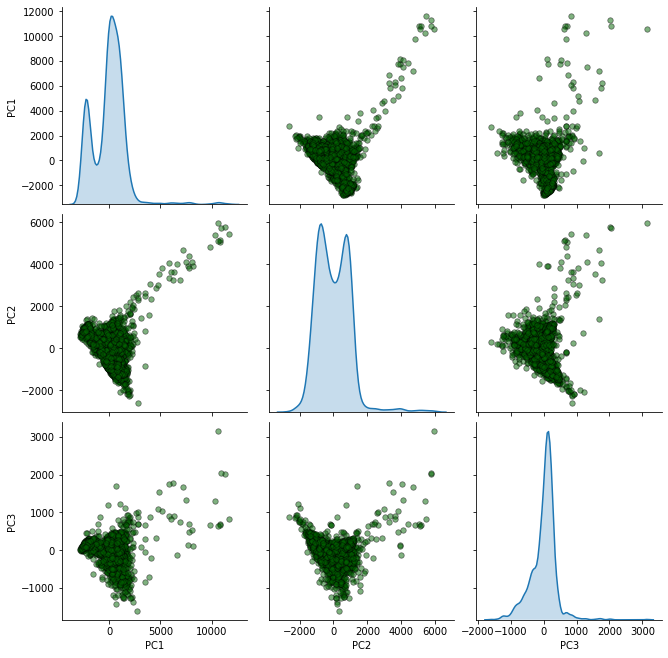

In [7]:
## We can now visualize the first three components via the pairwise scatter 
## plot that we have done earlier.
sbn.pairplot(PCA_df_X.iloc[:,:3], diag_kind = 'kde',
             plot_kws = {'alpha': 0.5, 's': 30, 'edgecolor': 'k', 'color': 'darkgreen'},
             height = 3)

## k-Means clustering



In [8]:
## Generate cluster results using KMeans in scikit-learn
from sklearn.cluster import KMeans  ## package for k-means clustering
from sklearn import metrics 
kmeanModel = KMeans(n_clusters=8, init='k-means++', n_init=10,
                    random_state=42) # using random_state to ensure reproducible
kmeanModel.fit(PCA_df_X)
## Now we have a cluster model and the cluster label for each data points
clusterLabel = kmeanModel.labels_
## Print out the unique values of our cluster label
print ( np.unique(clusterLabel) )

[0 1 2 3 4 5 6 7]


How do we know what k value is the best value? Let's try different k values and use the "Elbow rule" to find a reasonable k value for our clustering task.

In [10]:
## Average of the squared distances from the cluster centers of the respective clusters
distortions = [] 
## Sum of squared distances of samples to their closest cluster center
inertias = [] 
## Candidate number of clusters (k)
Kval = range(1,10) 
  
for k in Kval: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k, random_state=42) 
    kmeanModel.fit(PCA_df_X)     

    ## Calculate distortions using Euclidean distance with PCA tranformed data 
    distortions.append(sum(np.min(cdist(PCA_df_X, 
                                        kmeanModel.cluster_centers_, 
                                        'euclidean'),axis=1)) / PCA_df_X.shape[0]) 
    ## Calculate inertias (part of the KMeans output)
    inertias.append(kmeanModel.inertia_) 
  

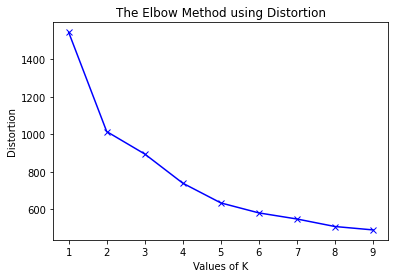

In [11]:
## Create the Elbow plot between distortions and different K values
plt.plot(Kval, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

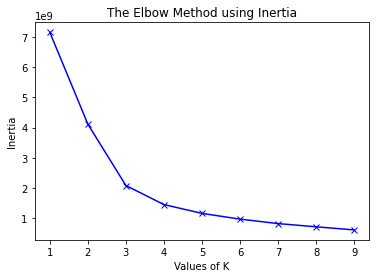

In [12]:
## Create the Elbow plot between inertias and different K values
plt.plot(Kval, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [14]:
## Fit final K-means clustering model with k = 4
kmeans = KMeans(init='k-means++', n_clusters=4, n_init=10, random_state=42)
kmeans.fit(PCA_df_X)
## Create the final cluter labels for the data
AVLcluster = kmeans.predict(PCA_df_X)


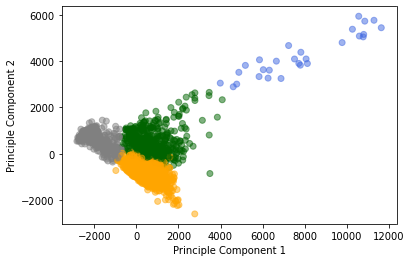

In [15]:
# We are now visualizing our cluster result in our feature space
# Each cluster is represented using different colors
# Define color for each class lables
colormap = np.array(["darkgreen", "orange", "grey", "royalblue"])
cpt = colormap[np.int_(AVLcluster)]

# Initialize a new matplotlib figure and its axes object.
fig, ax = plt.subplots()

# Creating the scatter plot with multiple clusters
scatter = ax.scatter(PCA_df_X[["PC1"]], PCA_df_X[["PC2"]], 
                     alpha=0.5, c=cpt)
ax.set_xlabel("Principle Component 1")
ax.set_ylabel("Principle Component 2")

fig.show()